# Image colorization using WGAN and UNET architecture

For the course of **Neural Networks and Deep learning**

**Students:**

Lorenzo Valentini<br>
Gianmarco Nagaro Quiroz

## 1 - Implementing the paper - Our Baseline

### 1.1- Loading Image Paths

In [7]:
import os
import glob
import time
import random
import pandas as pd

import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm # this module is useful to plot progress bars
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

We are using Imagenet, getting **10,000** images as training and **3,000** images as validation

In [5]:
path = "./imagenet/"

path_train = path +'train/'
path_val = path +'val/'
train_paths = glob.glob(path_train + "/**/*.JPEG", recursive=True)[:10000] # Grabbing all the image file names
val_paths = glob.glob(path_val + "/**/*.JPEG", recursive=True)[:3000] # Grabbing all the image file names

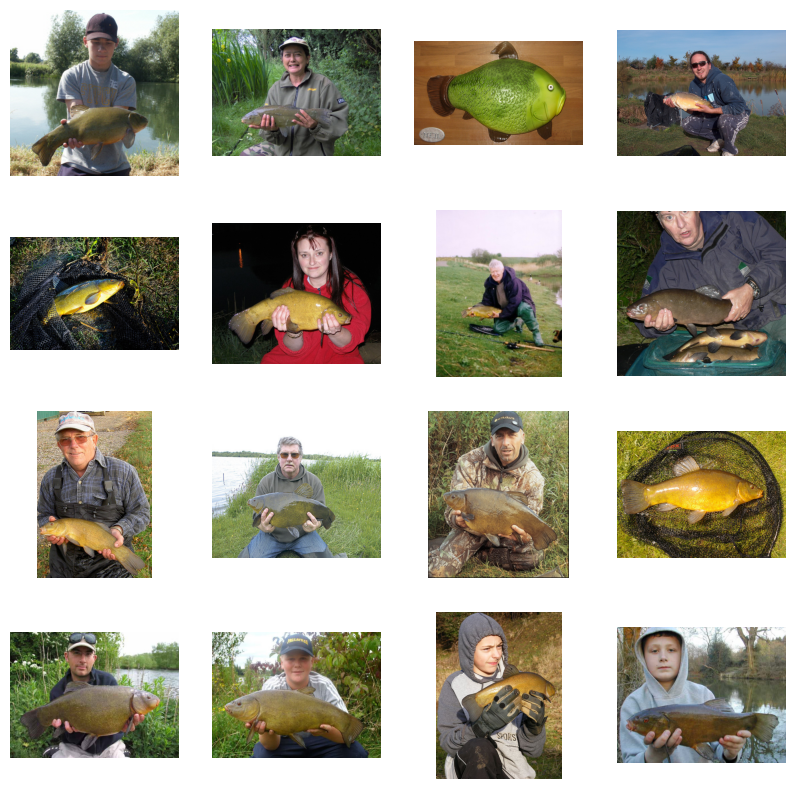

In [6]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2- Making Datasets and DataLoaders

This part of the code ensures all the images are resized uniformly and the dataloaders are made in a way that everything is handled correctly.

In [7]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=64, n_workers=0, pin_memory=True, **kwargs): 
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [8]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

C:\Users\gianm\AppData\Local\Temp\ipykernel_31484\115198831.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
C:\Users\gianm\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
C:\Users\gianm\AppData\Local\Temp\ipykernel_31484\115198831.py:10: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)


torch.Size([64, 1, 256, 256]) torch.Size([64, 2, 256, 256])
157 47


### 1.3- Generator proposed by the paper

This graph shows a standard U-net architecture, which we are trying to achieve as the baseline of our project.

![unet](https://miro.medium.com/v2/resize:fit:1400/1*VUS2cCaPB45wcHHFp_fQZQ.png)

This evidences three clear parts, the encoder, the bottleneck and the decoder. All of them are explained with more detail on the final report handed with this notebook.

In [9]:
class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, negative_slope, dorate):
        super(UNetEncoderBlock, self).__init__()
        self.model = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),

#            nn.Dropout(dorate),
        )
    def forward(self, x):
        x = self.model(x)
        return x
    
class UNetStartBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, negative_slope, dorate):
        super(UNetStartBlock, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),

        )
    def forward(self, x):
        x = self.model(x)
        return x

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, negative_slope, dorate):
        super(UNetDecoderBlock, self).__init__()
        self.model = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dorate),
        )
    def forward(self, x, skip_x):
        x = torch.cat([x, skip_x], dim=1)
        x = self.model(x)
        return x
    
class UNetDecoderInnerBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, negative_slope, dorate):
        super(UNetDecoderInnerBlock, self).__init__()
        self.model = nn.Sequential(
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x, skip_x):
        x = torch.cat([x, skip_x], dim=1)
        x = self.model(x)
        return x
    
class UNetBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, negative_slope, dorate):
        super(UNetBottleneck, self).__init__()
        self.model = nn.Sequential(
            nn.LeakyReLU(negative_slope),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        x = self.model(x)
        return x
    
class UNetOutput(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, negative_slope, dorate):
        super(UNetOutput, self).__init__()
        self.model = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.Tanh(),
        )
    def forward(self, x, skip_x):
        x = torch.cat([x, skip_x], dim=1)
        x = self.model(x)
        return x
    

    
class UNetAutoencoder(nn.Module):
    def __init__(self, nlayers, start_channels, kernel_size, stride, padding, negative_slope, dorate):
        super(UNetAutoencoder, self).__init__()
        
        self.encoderblocks = []
        self.decoderblocks = []
        
        self.encoderblocks.append(UNetStartBlock(1, start_channels, kernel_size, stride, padding, negative_slope, dorate))
        self.decoderblocks.append(UNetDecoderBlock(start_channels*(2**nlayers)*2, start_channels*(2**nlayers), kernel_size, stride, padding, negative_slope, dorate))
        self.decoderblocks.append(UNetDecoderBlock(start_channels*(2**nlayers)*2, start_channels*(2**nlayers), kernel_size, stride, padding, negative_slope, dorate))
        self.decoderblocks.append(UNetDecoderBlock(start_channels*(2**nlayers)*2, start_channels*(2**nlayers), kernel_size, stride, padding, negative_slope, dorate))

        for ii in range(0, nlayers):
            self.encoderblocks.append(UNetEncoderBlock(start_channels*(2**ii), start_channels*(2**(ii+1)), kernel_size, stride, padding, negative_slope, dorate))
            self.decoderblocks.append(UNetDecoderInnerBlock(start_channels*(2**((nlayers-ii-1)+2)), start_channels*(2**(nlayers-ii-1)), kernel_size, stride, padding, negative_slope, dorate))

        self.encoderblocks.append(UNetEncoderBlock(start_channels*(2**(ii+1)), start_channels*(2**(ii+1)), kernel_size, stride, padding, negative_slope, dorate))
        self.encoderblocks.append(UNetEncoderBlock(start_channels*(2**(ii+1)), start_channels*(2**(ii+1)), kernel_size, stride, padding, negative_slope, dorate))
        self.encoderblocks.append(UNetEncoderBlock(start_channels*(2**(ii+1)), start_channels*(2**(ii+1)), kernel_size, stride, padding, negative_slope, dorate))

        self.decoderblocks.append(UNetOutput(start_channels*2, 2, kernel_size, stride, padding, negative_slope, dorate))
        
        self.encoderblocks = nn.ModuleList(self.encoderblocks)
        self.bottleneck = UNetBottleneck(start_channels*(2**nlayers), start_channels*(2**nlayers), (3,3), stride, padding, negative_slope, dorate)
        self.decoderblocks = nn.ModuleList(self.decoderblocks)        

        
    def forward(self, x):
        self.passingx = []
        for module in self.encoderblocks:
            x = module(x)
            self.passingx.append(x)
            
        self.passingx.reverse()
        x = self.bottleneck(x)
            
        for ii, module in enumerate(self.decoderblocks):
            x = module(x, self.passingx[ii])
        return x

### 1.4- Discriminator

The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

In [10]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
#            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
#            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
#            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
#            nn.Dropout(0.3),
            nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
        )
    
    def forward(self, x):
        return self.model(x)

Let's take a look at its blocks:

In [11]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

And its output shape:

In [12]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [13]:
out.shape[1]

1

Talk about gradiant penalty

In [14]:
def gradient_penalty(D, xr, xf):
    T = torch.rand(xr.shape[0], 1, 256, 256).cuda()
    T = T.expand_as(xr)
    inter = T * xr + (1 - T) * xf
    inter.requires_grad_()    
    pred = D(inter)
    grads = autograd.grad(outputs=pred, inputs=inter, grad_outputs=torch.ones_like(pred), create_graph=True, retain_graph=True, only_inputs=True)[0]    
    penalty = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()    
    return penalty

### 1.5- GAN Loss

This deploys a GAN to calculate an extra loss for our training

In [15]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.6 Model Initialization

Model is initialized with standard weights and return a string when done successfully.

In [16]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.7 - Main function

This part calls the models done before and generates the network, you can also give different parameters to it to do a gridsearch with them.

Some of them are the two learning rates, the two betas, the Lambda value of L1 to make it compete with the GAN loss and the weight of the WGAN in the overall loss.


In [17]:
class MainModel(nn.Module):
    def __init__(self,deep, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.,gpw=0.2):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        self.gpw = gpw
        if net_G is None:
            self.net_G = init_model(UNetAutoencoder(nlayers = deep, start_channels = 64, kernel_size = (4,4), stride = 2, padding = 1, negative_slope = 0.2, dorate = 0.5), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        gp = gradient_penalty(self.net_D, real_image, fake_image.detach())
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5 + self.gpw*gp
        self.loss_D.backward()
        
        
    def getlosses(self):
        self.losses = [self.loss_D_fake.item(),self.loss_D_real.item(),self.loss_D.item(),self.loss_G_GAN.item(),self.loss_G_L1.item(), self.loss_G.item()]
    
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### 1.8 - Printing and Analysis functions


This functions make possible to generate a dataset with the loss at each stage, so we can compare different runs.
It also prints an two images during each epoch, with a nice layout indicating which is the original, fake and real image.

In [18]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def getlosses(model):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
  
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    #We get two examples 
    for i in range(2):
        ax = plt.subplot(2, 3, i*3+1 )
        ax.title.set_text('Grayscale')
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(2, 3, i*3 +2)
        ax.title.set_text('Fake')
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(2, 3, i*3 +3)
        ax.title.set_text('Real')
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def lossprinter(lossframe):
    columns=["Epoch","Iteration",'Disc Fake', 'Disc Real','Disc Overall',"GAN Loss","L1 Loss","Overall Loss"]
    for k in range(8):
        if len(loss_df.index) > 1:
            diff = np.round((loss_df.loc[len(loss_df.index)-1][k]-loss_df.loc[len(loss_df.index)-2][k]),3)
        else: diff = 0
        print(columns[k] +": "+ str(np.round(loss_df.loc[len(loss_df.index)-1][k],5))+" (" + f"{diff:+}" + ")")

In [19]:
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [20]:
import gc
torch.cuda.empty_cache()
gc.collect()

10

### 1.9 - Training function

The model is spawned with the desired characteristics and a dataframe is generated with it. Epochs are set and the training is set into motion.


We set display_every to display two images every x iterations inside an epoch. As our iterations are 157 in this case, only two images are displayed at iteration 150.

When the traning ends, the dataframe is populated with all the losses calculated each epoch.

This images make the notebook exceed 100MB for one training, so **they are removed on the final delivery of the project.**


In [62]:
from torch import autograd
import random

In [ ]:
model = MainModel(deep = 4,gpw=0.1).cuda()
epochs = 100


loss_df = pd.DataFrame([], columns=["Epoch","Iteration",'Disc Fake', 'Disc Real','Disc Overall',"GAN Loss","L1 Loss","Overall Loss"])
data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
for e in range(epochs):
    loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
    i = 0                                  # log the losses of the complete network
    display_every=150
    for data in tqdm(train_dl):
        model.setup_input(data) 
        model.optimize()
#        update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
        i += 1
        if (i % display_every == 0) and (e % 1 == 0):
            model.getlosses()
            loss_df.loc[len(loss_df.index)] = [e,i]+model.losses
            lossprinter(loss_df)
            visualize(model, data, save=False) # function displaying the model's outputs



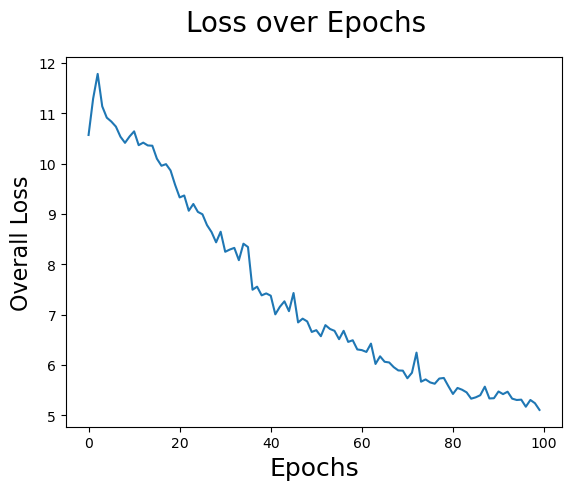

In [64]:
fig = plt.figure()
plt.plot(loss_df["Epoch"],loss_df["Overall Loss"])
fig.suptitle('Loss over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Overall Loss', fontsize=16)
fig.savefig('overall_loss.png')

In [65]:
loss_df.to_csv('./mylosses.csv') 
torch.save(model, "./mymodel.pth")

When several models are used, we use collect so our memory doesnt get flooded.

In [66]:
import gc
torch.cuda.empty_cache()
gc.collect()

49474

In [ ]:
model = MainModel(deep = 4,gpw=0.3).cuda()
epochs = 100


loss_df = pd.DataFrame([], columns=["Epoch","Iteration",'Disc Fake', 'Disc Real','Disc Overall',"GAN Loss","L1 Loss","Overall Loss"])
data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
for e in range(epochs):
    loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
    i = 0                                  # log the losses of the complete network
    display_every=150
    for data in tqdm(train_dl):
        model.setup_input(data) 
        model.optimize()
#        update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
        i += 1
        if (i % display_every == 0) and (e % 1 == 0):
            model.getlosses()
            loss_df.loc[len(loss_df.index)] = [e,i]+model.losses
            lossprinter(loss_df)
            visualize(model, data, save=False) # function displaying the model's outputs


## 2. Post-processing

Models and loss progression is saved to explore afterwards

In [68]:
loss_df.to_csv('./mylosses2.csv') 
torch.save(model, "./mymodel2.pth")

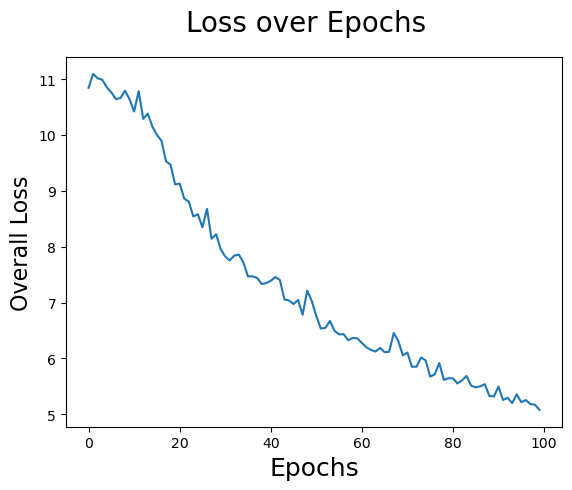

In [69]:

fig = plt.figure()
plt.plot(loss_df["Epoch"],loss_df["Overall Loss"])
fig.suptitle('Loss over Epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Overall Loss', fontsize=16)
fig.savefig('overall_loss.png')

Now we can see the final dataset over losses that enables us to do a comparison between different models

In [16]:
mydf = pd.read_csv('finalloss.csv')
mydf

,Unnamed: 0,Epoch,Iteration,Disc Fake,Disc Real,Disc Overall,GAN Loss,L1 Loss,Overall Loss
0,0,0.0,150.0,0.650176,0.212813,0.431494,1.493963,8.906035,10.399999
1,1,1.0,150.0,0.614153,0.254879,0.434516,1.314824,9.268370,10.583194
2,2,2.0,150.0,0.847840,0.252466,0.550153,1.698860,9.743654,11.442514
3,3,3.0,150.0,0.668423,0.244504,0.456463,1.240739,9.208626,10.449365
4,4,4.0,150.0,0.825319,0.211026,0.518173,1.392406,9.513839,10.906244
...,...,...,...,...,...,...,...,...,...
95,95,95.0,150.0,1.093142,0.294074,0.693608,1.044434,5.013659,6.058094
96,96,96.0,150.0,0.970584,0.301177,0.635881,1.002717,4.851974,5.854692
97,97,97.0,150.0,0.814462,0.392861,0.603662,0.898445,4.883804,5.782249
98,98,98.0,150.0,0.913796,0.358461,0.636129,0.885041,4.896847,5.781888
